In [1]:
from sim import make_two_blobs, make_parallel_lines, make_two_3d_circles, make_trefoil_knot, make_springs, \
perp_plots, compare_plots
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1234)

# Implementing t-SNE

## Abstract
**To be done**

## Background
In practice, high-dimensional data is often concentrated near a lower dimensional manifold. This can occur for a variety of reasons, but is commonly viewed as a signal that the underlying data-generating mechanism depends on significantly fewer parameters than the dimension of the observed data. Consider image data summarizing a single individual's face at a random distance and angle: as an array, each image could be extremely high dimensional, despite most of the variability depending on only two parameters. 

Recovering the underlying manifold structure is desirable in some applications and necessary in others. Data visualization is fundamentally easier in lower dimensional spaces; more accurate visualizations allow an analyst to exploit patterns in the data during modelling and inference. Computationally, low-dimensional data takes less memory to store, and is always faster to process or summarize with standard algorithms. Mathematically, low-dimensional data is unafflicted by the curse of dimensionality. For all of these reasons, the results of low-dimensional inference or modelling are generally more accurate and informative than inference performed on the original data. For example, consider analyzing images of a baseball player mid-throw. Each image could be viewed as an array in some larger space, say $\mathbb{R}^{N\times N}$. Interpolating between two such images in Euclidean space (e.g. drawing a line between the two arrays) would produce nonsensical, physically imposible results. One must learn the underlying image manifold, and then interpolate in that space.

Formally, learning an underlying manifold is necessary when the true data generating mechanism involves sampling points $y_i\in \mathbb{R}^d$, $i=1,...,n$ from some manifold $M\subseteq \mathbb{R}^d$, and then embedding these points into ambient space via a function $f:M\to \mathbb{R}^D$, $D>d$. The analyst observes $x_i = f(y_i)$ and needs to construct estimates $\widehat y_i$ of $y_i$. Different methods of manifold learning place different assumptions on $f$. For example, principal component analysis (PCA) assumes $f$ is linear, constructs the $d$ dimensional plane $M$ that explains most of the variability in the observed data, and takes $\widehat y_i$ to be the projection of $x_i$ onto that plane. PCA is fast, but fails to handle nonlinear embeddings. An alternative is Isomap, which assumes $f$ is an isometry (i.e. distance preserving), and thus tries to choose $\widehat y_i$ such that the distance between $\widehat y_i$ and $\widehat y_j$ is close to the distance between $x_i$ and $x_j$. Intuitively, points that are far apart in the ambient space should be sent to points that are far apart in the low-dimensional space, and points that are close together should stay close together. The key step in Isomap is to build a graph by defining an edge $x_ix_j$ with weight $||x_i-x_j||$ if $||x_i-x_j||$ is small (and no edge if this is large). Distances between distance points $x_k$, $x_\ell$ are estimated as the shortest path along this graph, and then multidimensional scaling is used to find a linear embedding which preserves these distances. Isomap is still quite fast, but fails when $f$ is not an isometry (e.g. when $f$ is only conformal). Furthermore, Isomap is only guaranteed to produce reliable estimates when the true $y_i$ are sampled uniformly from $M$.

Symmetric stochastic neighbor embedding (S-SNE) is another approach to nonlinear manifold learning which instead attempts to preserve a notion of probabilistic similarities between points. In the ambient space the data are assumed to be jointly Gaussain; a similarity matrix is constructed using the conditional probability that $x_j$ came from a Gaussian centered as $x_i$. S-SNE searches for low-dimensional $\widehat y_i$ that also come from a Gaussian distribution and preserve the similarity matrix from the ambient space, where "preserve" is measured using the Kullback–Leibler (KL) divergence. S-SNE struggles when one point has many neighbours all at a similar distance: for example, assume $x_1$ is at the center of a cirle and all $x_j$, $j>1$ live on this circle. Embedding the $x_i$ into one dimension would force many (very different) $x_j$ onto the same points. Naive solutions such as modifying the modifying the KL-divergence penalty result in horribly slow optimization problems. In this document we implement and study t-distributed stochastic neighbor embedding (t-SNE), which replaces the Gaussian assumption on $y_i$ with a t-distribution assumption. A heavier tailed distribution forces points at moderate distances in the ambient space to be embedded very far apart, and thus ameliorates crowding.


In particular, we implement t-SNE in basic python, and then significantly improve our implementation using numpy broadcasting, just-in-time (JIT) numba C++ compilation, and parallelization. Each version of our implementation is thoroughly benchmarked. The fastest versions of our implementation are then tested on simualted data, the MNIST digits dataset, and **SOME OTHER DATA.** Finally, we compare our implementation to PCA and Isomap on difficult nonlinear simulations as well as the real datasets previously mentioned.

## Description of Algorithm

### Preliminaries
The algorithm begins by converting high-dimensional data $x_1,...,x_n$ into an $n\times n$ matrix of conditional probabilities. These conditional probabilities measure the similarity between points under a pre-specified Gaussian distribution. More formally, consider a multivariate Gaussian distribution centered at a single point $x_i$ with isotropic variance $\sigma_i^2$; let $f_i$ be the probability density function for this distribution. The conditional probability $p_{j|i}$ is the probability that $x_j$ would pick $x_i$ as its neighbour (out of all $\{x_1,...,x_n\}\setminus \{x_j\}$ if neighbours were chosen randomly with probabilities $f_i(x_j)$. In symbols:
$$
p_{j|i} = \frac{\exp(-||x_i-x_j||^2/2\sigma_i^2)}{\sum_{k\neq i}\exp(-||x_i-x_k||^2/2\sigma_i^2)}.
$$
Conditional probabilities are converted to joint probabilities via
$$
p_{ij} = \frac{p_{j|i}+p_{i|j}}{2n}.
$$
If $x_i$ and $x_j$ are close together from the perspective of a Gaussian distribution, then $p_{ij}$ will be large. If they are far apart, then $p_{ij}$ will be small. In this sense $\sigma_i^2$ controls what "close together" means; these variances are chosen so that the entropy equals a user specified value called the perplexity:
$$
\text{Perp}(\sigma_1,...,\sigma_n) = 2^{-\sum_j p_{j|i}\log_2p_{i|j}}.
$$
Low-dimensional points $y_1,...,y_d$ are modelled with a $t$ distribution, wherein the joint probabilities are
$$
q_{ij} = \frac{(1+||y_i-y_j||)^{-1}}{\sum_{k\neq \ell}(1+||y_k-y_\ell||)^{-1}}.
$$
Intuitively, we want the distribution of the $y_i$ to "look similar" to the distribution of the $x_i$. The KL-divergence measures similarity between probability distributions; as such t-SNE aims to minimize
$$
KL(P||Q) =\sum_{i, j}p_{ij}\log\bigg(\frac{p_{ij}}{q_{ij}}\bigg).
$$
One can compute the gradient directly as
$$
\frac{dKL(P||Q)}{dy_i} = 4\sum_{j}\frac{p_{ij}-q_{ij}}{(1+||y_i-y_j||)^{-1}}(y_i-y_j).
$$

### The Algorithm

We now have everything we need to state the main algorithm.

---
**Algorithm 1:** t-SNE  
**Inputs:**  
High dimensional data - $X = \{x_1,...,x_n\}$,  
Desired perplexity - $Perp$,  
Number of iterations - $T$,  
Learning rate - $\eta$,  
Momentum - $\alpha(t)$  
**Outputs:**  
Low-dimensional latent factors - $Y = \{y_1,...,y_n\}$.

**Begin:**
1. Optimize $\sigma_i$ to the desired perplexity $Perp$ (e.g. with binary search).
2. Compute $p_{ij}$ using $X$.
3. Sample initial solution $Y^{(0)}\sim N(0, 10^{-4})$ entrywise.
4. For $t=0,...,T$:
  1. Compute $q_{ij}$ using $Y^{(0)}$.
  2. Compute $dKL(P||Q)/dY$ using $Y^{(0)}$.
  3. Set $Y^{(t)}=Y^{(t-1)}+\eta dKL(P||Q)/dY - \alpha(t)(Y^{(t-1)}-Y^{(t-2)})$  
  
**End**

---

For completeness, we also outline binary search.

---
**Algorithm 2:** Binary search  
**Inputs:**  
Evaluation function - $f$,  
Target value - $target$,  
Tolerance - $tol$,  
Number of iterations - $T$,  
Lower bound - $LB$,  
Upper bound - $UB$,  
**Outputs:**  
Estimated solution $x$ to $f(x)=target$.

**Begin:**
1. For $t=1,...,T$ or until converged:
  1. Set $guess = (LB+UB)/2$.  
  2. Compute $val=f(guess)$.
  3. If $val > target$, set $upper=guess$. Otherwise set $lower=guess$.
  
**End**

---


### Accessories
Overflow is a concern when computing $||x_i-x_j||$ in high dimensions. As such, we augment our implementation to run PCA whenever the dimension of the input data is larger than $30$. t-SNE is run on the resulting $30$-dimensional linear factors.

The above algorithm offers significant gains over S-SNE, but can nonetheless be improved with a small number of tricks. The first trick is known as exaggeration: for the first several (say $50$) iterations of t-SNE, we use $4p_{ij}$ instead of $p_{ij}$. The $q_{ij}$, which always sum to $1$, will never be able to adequately model these exaggerated joint probabilities. Consequently, the cost function forces all of the $q_{ij}$ to model the largest probabilities; this has the effect of forming tight widely seperated clusters early on, which makes it easier for the clusters to move around eachother once the exaggeration has been removed.

Another trick is to use a learning rate schedule, $\eta(t)$, instead of a constant $\eta$. Adaptive learning rates accelerate training in the early stages of the algorithm (which compounds the effects of exaggeration), as well as reduce the risk of choosing an inappropriate learning rate for the application at hand. Our implementation of t-SNE allows for custom learning rate functions (as long as $\eta_t$ depends only on $t$, $\eta_{t-1}$, $\eta_0$, and constants), but also comes with the following default schedules:
$$
\begin{align*}
&\text{Constant:}\quad \eta_{t+1} = c, \quad c>0, \\
&\text{Time-based:}\quad \eta_{t+1} = \frac{\eta_t}{1+dt}, \quad d>0, \\
&\text{Step-based:}\quad \eta_{t+1} = \eta_0d^{\text{floor}(1+t)/r}, \quad d>0, r>0, \\
&\text{Exponential :}\quad \eta_{t+1} = \eta_0\exp(-dn), \quad d>0.
\end{align*}
$$
**COMMENT ON LEARNING RATES; WHAT THESE PARAMETERS MEAN.** Finally, we choose a small momentum term for the first few iterations (e.g. $\alpha(t)=0.5$ for $t<250$). Once the data are reasonably well seperated, increasing the momentum allows us to speed toward an extreme point (e.g. $\alpha(t)=0.2$ for $t\geq 250$).

## Optimization

**Need to talk about this. Find all distances using highly optimized sklearn routines. Used broadcasting for $p_{j|i}$ and $q_{ij}$ with numpy. Wrote each row of the gradient as a dot product. JIT compilation of key functions (TBD). Parallelized optimizing $\sigma_i$ and computing the gradient.**

**Need to write slow code. Idea: make three versions of each main function (P, Q, grad) with 1) horrible python, 2) nice vectorized python, 3) fancy parallel numba. Build wrappers for each with a flag `optimized = 0, 1, 2` that calls the correct function. Take `optimized` as an argument for t-SNE.**

**We should move to multiple `.py` files at this point too.**

## Applications to Simulated Data
**TBD. Need to write nice custom scripts for generating test cases. Should be its own `.py` file as well.**

Given that t-SNE output is influenced by a randomly chosen initial state, the exact same function inputs can yield vastly different results. Below, we show the output from 3 different (identical) runs of t-SNE, starting from three parallel lines with moderate spacing. This initial example is meant to illustrate that there do not exist specific inputs that give known outputs for t-SNE. However, we can produce datasets that have known grouping structures (denoted by separate colors) and observe how well t-SNE preserves these grouping structures. In this example, we note that the all of the outputs, though different in appearance, preserve the three lines in the original dataset.

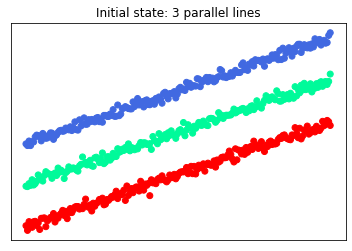

In [3]:
X, labs = make_parallel_lines(spacing = 40, num_lines = 3)
cdict = {1: 'red', 2: 'mediumspringgreen', 3: 'royalblue'}
plt.scatter(x = X[:, 0], y = X[:, 1], c = np.array(list(map(lambda x: cdict[x], labs))))
plt.title("Initial state: 3 parallel lines")
plt.xticks([])
plt.yticks([]);

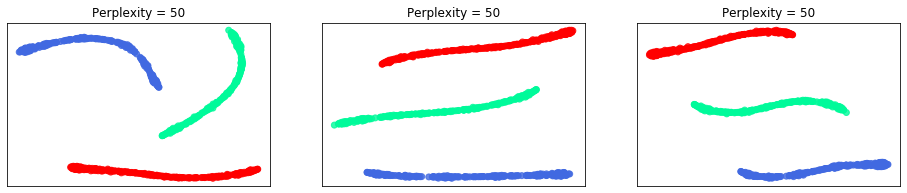

In [3]:
perp_plots(X = X, labs = labs, perp_vec = [50, 50, 50])

Next, we demonstrate how t-SNE performs across a range of perplexity values for four simple datasets: 

- Two clusters of 500-dimensional Gaussian data with equal variance (of which 2 dimensions are shown in the top row of the grid below)
- Two clusters of 500-dimensional Gaussian data with unequal variance (of which 2 dimensions are shown in the top row of the grid below)
- Two parallel lines with very little spacing between them
- Three parallel lines with moderate spacing, which are the same lines that were used in the demonstration above

From these examples, we can extract a few insights about the performance of t-SNE:

- Given a perplexity value that is appropriate for a given dataset, t-SNE appears to be quite proficient at preserving clusters (both for high dimensional and low dimensional starting points)
- Shape is not necessarily preserved through the t-SNE algorithm. For instance, t-SNE does not return two clusters of unequal size from the 500-dimensional Gaussians with unequal variance
- t-SNE has success across a wide range of perplexity values for groups that can be easily separated (e.g., the Gaussian blobs). For datasets with less discernable separation (e.g., two tight parallel lines), the choice of perplexity value is critical

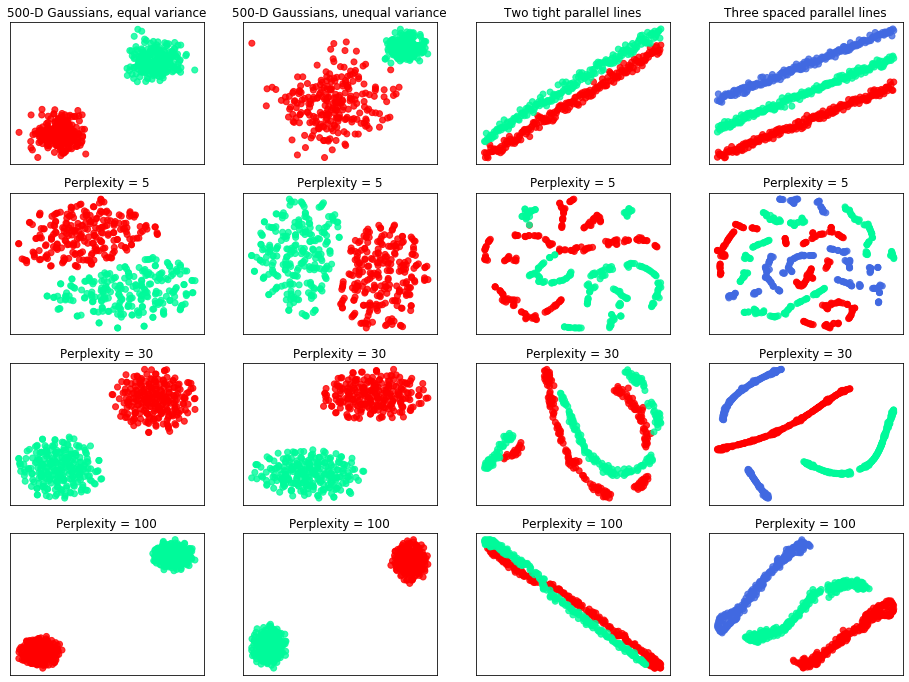

In [4]:
compare_plots(data_list = [make_two_blobs(), make_two_blobs(blob1_sd = 1.5), make_parallel_lines(), \
                              make_parallel_lines(spacing = 40, num_lines = 3)], \
                 title_list = ["500-D Gaussians, equal variance", \
                               "500-D Gaussians, unequal variance", \
                               "Two tight parallel lines", \
                              "Three spaced parallel lines"])

As the shapes considered above were quite simple, we also tested t-SNE on 3-dimensional objects with more complicated structures:

- Linked circles
- A trefoil knot
- Intertwined springs

While t-SNE is typically used for dimensionality reduction of high dimensional data, we chose more complicated structures in three dimensions due to ease of visualization. At low perplexity values, t-SNE does not perform well on these shapes. However, at moderate perplexity values, t-SNE appropriately flattens the 3-dimensional shapes into reasonable clusters, and at high perplexity values, more of the original structure is shown (e.g., the linking of the two circles)

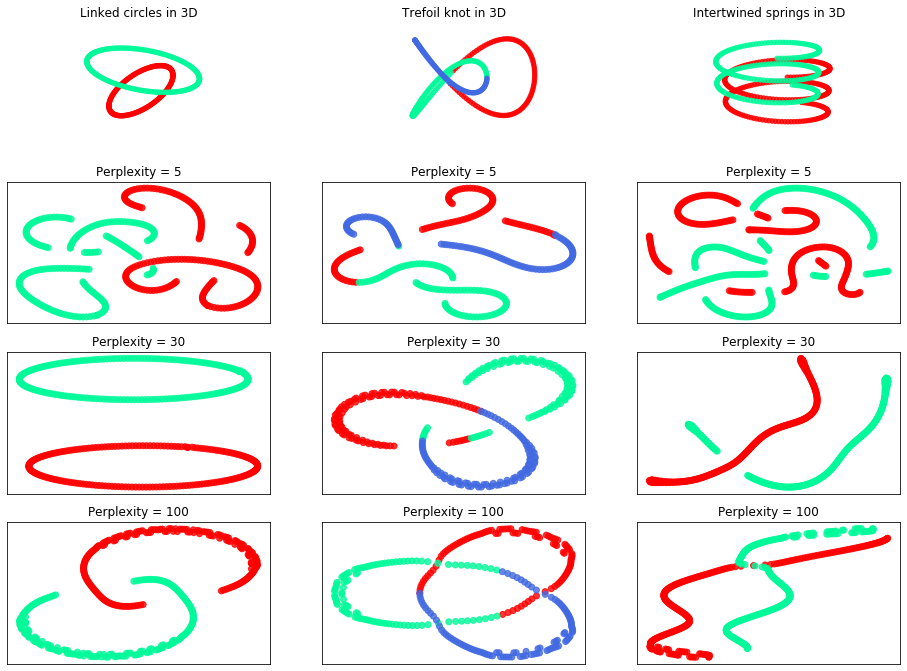

In [2]:
compare_plots(data_list = [make_two_3d_circles(), make_trefoil_knot(), make_springs()], \
                 title_list = ["Linked circles in 3D", \
                               "Trefoil knot in 3D", \
                               "Intertwined springs in 3D"], plot_3d = True)

Lastly, we were interested in studying the evolution of the t-SNE algorithm as a function of the iteration number. At least for the linked circles and trefoil knot, we still see evidence of t-SNE's random starting point at step 10, and then the appropriate shapes quickly begin to form. 

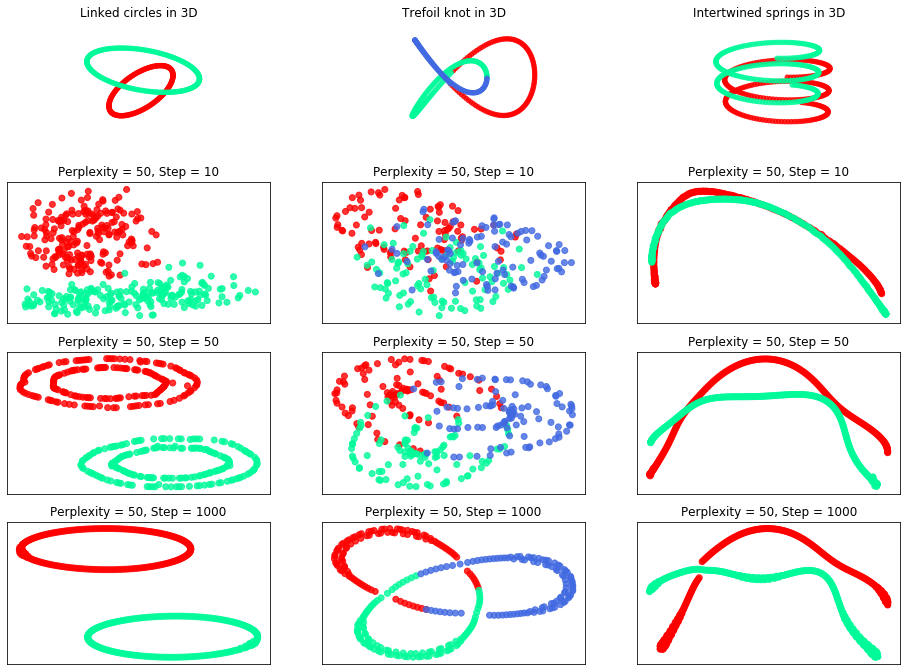

In [3]:
compare_plots(data_list = [make_two_3d_circles(), make_trefoil_knot(), make_springs()], \
                 title_list = ["Linked circles in 3D", \
                               "Trefoil knot in 3D", \
                               "Intertwined springs in 3D"], plot_3d = True, perp_plot = False, step_plot_perp = 50)

## Applications to Real Data
**TBD. MNIST + one bio one.**

## Comparison to Competing Algorithms
**Pick two other algorithms. Let's decide these today. PCA and Isomap? Need have short sections describing each algorithm. Test conformal fishbowl.**

**One simulation for visual performance, one real data example for scalability? Use MNIST so we don't need to re-run it?**

## Discussion
**TBD**

## References

\[1\] L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. Journal of Machine Learning Research 9(Nov):2579-2605, 2008.

\[2\] Vin de Silva and Joshua B. Tenenbaum. Global versus local methods in nonlinear dimensionality reduction. Proccedings of the 15th International Convference on Neural Information Processing Systems. Jan 2002.


\[3\] Dmitry Kobak, George Linderman, Stefan Steinerberger, Yuval Kluger, and Philipp Berens. Heavy-tailed kernels reveal a finer cluster structure in t-SNE visualisations. ECML PKDD 2019. doi: 10.1007/978-3-030-46150-8_8

\[4\] L.J.P. van der Maaten. Apr 2021. https://lvdmaaten.github.io/tsne/.

\[5\] Yann LeCun, Corinna Cortes, and Christopher J.C. Burges. The MNIST Database. Apr 2021. http://yann.lecun.com/exdb/mnist/.

\[6\] UCI Machine Learning Respository. Gene expression cancer RNA-seq Data Set. Jun 2016. https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#.

\[7\] Allen Institute for Brain Science. Human M1 10x. Apr 2021. https://portal.brain-map.org/atlases-and-data/rnaseq/human-m1-10x.

\[8\] Wattenberg, et al., "How to Use t-SNE Effectively", Distill, 2016. http://doi.org/10.23915/distill.00002